In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, precision_recall_curve
import sys
from pathlib import Path

ROOT_DIR = Path.cwd().parents[0]
sys.path.append(str(ROOT_DIR))

from src.preprocessing import preprocess_data


# loading our train data

train_path = ROOT_DIR / "data" / "raw" / "train.csv"

train_data = pd.read_csv(train_path, index_col='id')

# taking our target column as y
y = train_data['diagnosed_diabetes']
X = train_data.drop(columns="diagnosed_diabetes")

# print(X.head(5))

# extracting categorical and numkerical columns

cat_cols = [col for col in X.columns if X[col].dtype == 'object']

num_cols = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']

#print(cat_cols, num_cols)

#Splitting our data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=1)
#print(X_train.shape, "\n", X_valid.shape)

#Creatin A column Tranformer for preprocessing the data

ordinal_cat_cols = ["education_level", "income_level"]
nominal_cat_cols = ["gender", "ethnicity","smoking_status","employment_status"]

education_order = ['No Formal', 'Highschool','Graduate','Postgraduate']
income_order = ['Low','Lower-Middle','Middle','Upper-Middle','High']





In [2]:
processing = preprocess_data(num_cols=num_cols, ordinal_cat_cols=ordinal_cat_cols, nominal_cat_cols=nominal_cat_cols)

X_train_processed = processing.fit_transform(X_train)
X_valid_processed = processing.transform(X_valid)

print(X_train_processed.shape)

(560000, 31)


In [12]:
# building Logistic regression model and checking its performance
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline(steps=[("preprocessing", processing),
                                   ("logistic_reg", LogisticRegression(class_weight='balanced', max_iter=200, random_state=1))])

log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict_proba(X_valid)[:,1]
print(y_pred.shape)

print(y_pred[0:5])

roc_auc = roc_auc_score(y_valid, y_pred)
print(roc_auc)


(140000,)
[0.34329219 0.63095326 0.85272293 0.39148671 0.29826079]
0.692519708082572


In [29]:
#calculating log-loss and confusion matrix
 
ll = log_loss(y_valid, y_pred)

y_pred_label = (y_pred >= 0.6).astype(int)
conf_matrix = confusion_matrix(y_valid, y_pred_label)

print("Log Loss Score :", ll,"\n")
print("Confusion Matrix -")
print(conf_matrix)


Log Loss Score : 0.6322261158911764 

Confusion Matrix -
[[45809  6713]
 [55610 31868]]


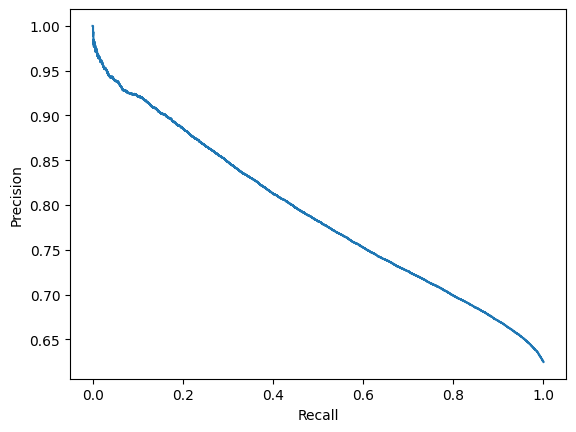

In [16]:
# plotting PR curve

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [31]:
# Getting coefficient values of our processing and regression

features = (log_reg_pipeline.named_steps["preprocessing"].get_feature_names_out())

reg_coef = (log_reg_pipeline.named_steps["logistic_reg"].coef_[0])

df = pd.DataFrame({"feaures": features, "coefficients" : reg_coef})

df = df.sort_values(by="coefficients", ascending=False)

print(df.shape)

print(df.head(5))
print(df.tail(5))

(31, 2)
                                    feaures  coefficients
15  num_processing__family_history_diabetes      0.564381
0                       num_processing__age      0.314750
14            num_processing__triglycerides      0.108251
6                       num_processing__bmi      0.099511
13          num_processing__ldl_cholesterol      0.051583
                                              feaures  coefficients
23             nominal_processing__ethnicity_Hispanic     -0.035077
10                         num_processing__heart_rate     -0.050648
12                    num_processing__hdl_cholesterol     -0.061089
3                          num_processing__diet_score     -0.071217
2   num_processing__physical_activity_minutes_per_...     -0.375146
